## Classification - Predicting if a blight-ticket will be paid on time


**Research question** 

The City of Detroit has a big Issue with blight violations and unpaid blight-tickets. I want to build a good and sparse model to predict, whether a given blight ticket will be paid on time. 


**Data Describtion**

The data for this assignment stems from the [Detroit Open Data Portal](https://data.detroitmi.gov/):
- train.csv (all tickets issued 2004-2011)
- test.csv (all tickets issued 2012-2016)

Columns - train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv. All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

**Methodology**

- Feature selection
    - first intuitive feature selection (getting rid of variables with too many or only one unique value)
    - testing the relation between the remaining variables and the target compliance
- training a Logistic Regression classifer using grid searching for C
- trainign the final model with C = 0.1, that maximizes the auc index

**Results**

The final model uses the features **'violation_code', 'disposition', 'discount_amount', 'judgment_amount'** for prediction. The area under the curve is 0.789. 


In [38]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from scipy import stats
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
#loading the test and train datasets
df_test = pd.read_csv("test1.csv")
df_train = pd.read_csv("train1.csv", encoding = "latin1")
df_test.set_index('ticket_id', inplace=True) 
df_train.set_index('ticket_id', inplace=True) 
df_train.dropna(subset=["compliance"], axis=0, inplace = True) 

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
#dropping the columns from train-dataset, that are not in the test dataset
X_train = df_train.drop(['payment_amount','payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance_detail'] , axis = 1)

In [41]:
#explore the count of values for some variables
print("zip_code", len(X_train["zip_code"].unique()))
print("clean_up_cost", len(X_train["clean_up_cost"].unique()))
print("grafitti_status", len(X_train["grafitti_status"].unique()))
print("violation_zip_code", len(X_train["violation_zip_code"].unique()))
print("violator_name", len(X_train["violator_name"].unique()))
print("inspector_name", len(X_train["inspector_name"].unique()))
print("agency_name", len(X_train["agency_name"].unique()))
print("disposition", len(X_train["disposition"].unique()))
print("violation_code", len(X_train["violation_code"].unique()))
print("discount_amount", len(X_train["discount_amount"].unique()))

zip_code 4314
clean_up_cost 1
grafitti_status 1
violation_zip_code 1
violator_name 84657
inspector_name 159
agency_name 5
disposition 4
violation_code 189
discount_amount 13


In [42]:
#first intuitive feature selection 
X_train = X_train.drop(['violation_street_name', 'grafitti_status', 'mailing_address_str_name', 'clean_up_cost', 'inspector_name', 'state', 'city', 'violation_street_number', 'late_fee', 'admin_fee', 'fine_amount', 'state_fee', 'violation_description', 'country', 'mailing_address_str_number', 'non_us_str_code', 'violation_street_number', 'violation_zip_code', 'violator_name', 'zip_code'], axis = 1)
X_test = df_test.drop(['violation_street_name', 'grafitti_status', 'mailing_address_str_name', 'clean_up_cost', 'inspector_name','state', 'city', 'violation_street_number', 'late_fee', 'admin_fee', 'fine_amount', 'state_fee', 'violation_description', 'country', 'mailing_address_str_number', 'non_us_str_code', 'violation_street_number', 'violation_zip_code', 'violator_name', 'zip_code'] , axis = 1)

In [43]:
#check relations of variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

for i in ["violation_code", "disposition", "agency_name"]:
    c = cramers_v(X_train[i], X_train["compliance"])
    print("Cramers V:", i, c)
    print("---------")

Cramers V: violation_code 0.11256353092463021
---------
Cramers V: disposition 0.349473162539608
---------
Cramers V: agency_name 0.06464381608563328
---------


In [44]:
X_train.groupby(['agency_name'])[['compliance']].mean()

,compliance
agency_name,
"Buildings, Safety Engineering & Env Department",0.060743
Department of Public Works,0.089961
Detroit Police Department,0.131720
Health Department,0.065851
Neighborhood City Halls,0.000000


In [28]:
X_train.groupby(['disposition'])[['compliance']].mean()

,compliance
disposition,
Responsible (Fine Waived) by Deter,1.000000
Responsible by Admission,0.275016
Responsible by Default,0.038203
Responsible by Determination,0.307300


In [45]:
#calculate time from issue to hearing in both datasets
X_train["ticket_issued_date"] = pd.to_datetime(X_train["ticket_issued_date"])
X_train["hearing_date"] = pd.to_datetime(X_train["hearing_date"])
X_train["Issue-to-hearing"] = X_train["hearing_date"] - X_train["ticket_issued_date"] 
X_train["Issue-to-hearing"] = X_train["Issue-to-hearing"].apply(lambda x: x.days if not (pd.isnull(x)) else pd.NaT)
mean = X_train["Issue-to-hearing"].mean(axis = 0)
X_train["Issue-to-hearing"].replace(np.nan, mean, inplace = True)
X_train["Issue-to-hearing"] = X_train["Issue-to-hearing"].astype("float")
X_train = X_train.drop(['ticket_issued_date', 'hearing_date'], axis = 1)

In [46]:
#check pointbiserial correlation for the continous variables
for i in ["Issue-to-hearing","discount_amount", "judgment_amount"]:
    pb = stats.pointbiserialr(X_train["compliance"], X_train[i])
    print(i,": ", pb)
    print("---------")

Issue-to-hearing :  PointbiserialrResult(correlation=-0.004672096558149998, pvalue=0.06174349771682061)
---------
discount_amount :  PointbiserialrResult(correlation=0.15607267980266504, pvalue=0.0)
---------
judgment_amount :  PointbiserialrResult(correlation=-0.05263748458313446, pvalue=1.79279435680102e-98)
---------


In [47]:
X_train.groupby("compliance").mean()

,discount_amount,judgment_amount,Issue-to-hearing
compliance,,,
0.0,0.008700,431.580958,72.729231
1.0,2.590325,280.886229,71.601231


In [48]:
#further droppings for the final dataset
X_train = X_train.drop(["compliance", "Issue-to-hearing", "agency_name"], axis = 1)

In [49]:
#standardizing the continous variables
from sklearn.preprocessing import StandardScaler
X_train[["judgment_amount", "discount_amount"]] = StandardScaler().fit_transform(X_train[["judgment_amount", "discount_amount"]])
X_test[["judgment_amount", "discount_amount"]] = StandardScaler().fit_transform(X_test[["judgment_amount", "discount_amount"]])

In [50]:
#dummy-coding the categorical variables of interest
cat_vars=['disposition','violation_code']
for var in cat_vars:
    dum = pd.get_dummies(X_train[var], prefix=var)
    X_train = pd.concat([X_train, dum], axis=1)
    X_train.drop([var], axis = 1, inplace=True)
    dum = pd.get_dummies(X_test[var], prefix=var)
    X_test = pd.concat([X_test, dum], axis=1)
    X_test.drop([var], axis = 1, inplace=True)  

In [51]:
y_train = df_train.loc[:,"compliance"]
    
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, random_state=1)

In [52]:
grid_values = {'C': [0.001, 0.01, 0.1, 1, 10]}
LR = LogisticRegression(solver ='liblinear')
grid= GridSearchCV(LR, param_grid = grid_values, scoring= 'roc_auc')
grid.fit(x_tr, y_tr)
decisionf = grid.decision_function(x_te) 
print('Test set AUC: ', roc_auc_score(y_te, decisionf))
print('Grid best parameter (max. AUC): ', grid.best_params_)
print('Grid best score (AUC): ', grid.best_score_)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Test set AUC:  0.7847925887855366
Grid best parameter (max. AUC):  {'C': 0.1}
Grid best score (AUC):  0.7899095504175344


In [53]:
#LG-Model with C = 0.1
LR = LogisticRegression(C=0.1, solver ='liblinear')
LR.fit(x_tr, y_tr)
yhat = LR.predict(x_te)
y_score = LR.decision_function(x_te)
auc = roc_auc_score(y_te, y_score)
auc

0.7847925887855366

Confusion matrix, without normalization
[[  319  2561]
 [   25 37065]]


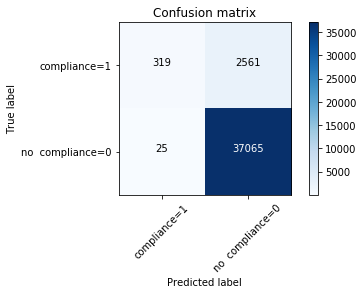

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(y_te, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['compliance=1','no  compliance=0'],normalize= False,  title='Confusion matrix') 

In [55]:
#preparing X_test for new predictions

coltr = X_train.columns.tolist()
colte = X_test.columns.tolist()
col_only_train = []
for i in coltr:
    if i not in colte:
        col_only_train.append(i)
col_only_test= []

for i in colte:
    if i not in coltr:
        col_only_test.append(i)

#Adding for the missing columns in test set default value 0
for c in col_only_train:
    X_test[c] = 0

# putting order of columns in same order in both sets
X_test.drop([i for i in col_only_test],axis = 1, inplace = True)

#dropping columns that are only in the test set
X_test = X_test[X_train.columns]    


In [56]:
#predicting values for X-test dataset
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.9 , 0.1 ],
       [0.98, 0.02],
       [0.95, 0.05],
       ...,
       [0.94, 0.06],
       [0.94, 0.06],
       [0.95, 0.05]])